## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally install and import torchensemble package for ensemble learning

In [1]:
# For Colab users
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# For import .py file
# you can copy path using right click - path copy
import sys
sys.path.insert(0,'/content/drive/MyDrive/Final_Project/normal')
# sys.path.insert(0,'/content/drive/MyDrive/final_proj_colab/normal')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import random  
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import importlib

## (Optional) Sample Visualization
You can see actual sample images and sorted class indices. Additional matplotlib package is needed.

In [4]:
# Just for reference: see actual samples
import matplotlib.pyplot as plt

alphabet = {
        'A(a)' : '0', 'B(b)' : '1', 'C(c)' : '2', 'D(d)' : '3', 'E(e)' : '4', 'F(f)' : '5', 
        'G(g)' : '6', 'H(h)' : '7', 'I(i)' : '8', 'J(j)' : '9', 'K(k)' : '10','L(l)' : '11', 
        'M(m)' : '12', 'N(n)' : '13', 'O(o)' : '14', 'P(p)' : '15', 'Q(q)' : '16', 'R(r)' : '17', 
        'S(s)' : '18', 'T(t)' : '19', 'U(u)' : '20', 'V(v)' : '21', 'W(w)' : '22', 'X(x)' : '23', 
        'Y(y)' : '24', 'Z(z)' : '25'
    }

7


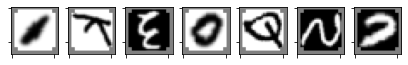

progress label:  8 10 12 14 16 18 20 22 
( I(i) K(k) M(m) O(o) Q(q) S(s) U(u) W(w) )


In [5]:
# Just for reference: see actual samples

#load_sample = np.load('./data/emnist_progress_normal_data/sample_data.npy', allow_pickle=True).item()
load_sample = np.load('/content/drive/MyDrive/Final_Project/emnist_progress_normal_data/sample_data.npy', allow_pickle=True).item()
sample_data, sample_label = load_sample['train_data'], load_sample['train_label']
print(len(sample_data))


plt.figure(figsize=(len(sample_data),len(sample_data)))
for i in range(len(sample_data)):
    plt.subplot(1, len(sample_data), i+1)
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.imshow(sample_data[i], cmap='gray')
    
plt.show()
print("progress label: ", end=' ')
label_str = '('

for i in range(len(sample_label)):
    print(int(sample_label[i]), end=' ')
    label_str += " " + list(alphabet.keys())[int(sample_label[i])]
label_str += " )"
print()
print(label_str)

In [6]:
# Use 0th GPU for training
torch.cuda.set_device(0)

In [7]:
# fix random seed to increase reproducibility
# NOTE: Do not modify here!

random_seed = 7
torch.manual_seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
%env CUBLAS_WORKSPACE_CONFIG=:16:8

def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
# you can modify this
num_workers = 1

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [8]:
# NOTE: you can modify mean and std for normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

batch_size =128

In [9]:
# NOTE: modify path for your setting

from data_utils import Mydataset, collate_fn

#train_path = './data/emnist_progress_normal_data/train'
#valid_path = './data/emnist_progress_normal_data/valid'
train_path = '/content/drive/MyDrive/Final_Project/emnist_progress_normal_data/train'
valid_path = '/content/drive/MyDrive/Final_Project/emnist_progress_normal_data/valid'

train_ds = Mydataset(train_path, transform=transform, train=True)
valid_ds = Mydataset(valid_path, transform=transform, train=False)

train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valid_dl= DataLoader(valid_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

0 load from 0 to 5000
1 load from 5000 to 10000
2 load from 10000 to 15000
3 load from 15000 to 20000
4 load from 20000 to 25000
5 load from 25000 to 30000
6 load from 30000 to 35000
7 load from 35000 to 40000
8 load from 40000 to 45000
9 load from 45000 to 50000
0 load from 0 to 5000
1 load from 5000 to 10000


In [10]:
import time

def train(model, model_optim, loss_func, max_epoch, train_dl, valid_dl, 
          load_path=None, save_path='./model.pt'):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Load your states
    loaded_epoch = 0
    loaded_best_acc = -1
    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_best_acc = state["best_acc"]
        # ...
    start_time = time.time()
        
    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
    
    best_valid_accuracy = 0 if loaded_best_acc == -1 else loaded_best_acc

    for epoch in np.array(list(range(max_epoch - loaded_epoch))) + loaded_epoch:
        n_samples = 0
        n_correct = 0
        model.train()
        for step, sample in enumerate(train_dl):
            img, label = sample
            
              
            outputs = model([img, label] )
            
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Problem 4: implement optimization part  
            model_optim.zero_grad()
            label_for_lossftn =[]
            for data in label:
                label_for_lossftn.append(data[-1])
            label_for_lossftn = torch.tensor(label_for_lossftn)
            label_for_lossftn = (label_for_lossftn.type(torch.LongTensor)).cuda()

            loss = loss_func(outputs[:,-1,:], label_for_lossftn)
            loss.backward(loss)
            model_optim.step()          
            
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            
            # you can modify below train evaluation code
            
            n_samples += len(label)
            for j in range(len(label)):
                n_correct += (outputs[j].argmax(-1)[-1] == label[j][-1].cuda()).sum().item()
            
            if (step + 1) % print_interval == 0:
                print('epoch:', epoch + 1, 'step:', step + 1, 'loss:', loss.item(), 'accuracy:', 100 * (n_correct / n_samples))
                elapsed_time = time.time() - start_time
                print('elapsed time : %d h %d m %d s' % (elapsed_time / 3600, (elapsed_time % 3600) / 60, (elapsed_time % 60)))            
                
        # you can modify evaluation code
                
        n_samples = 0
        n_correct = 0
        with torch.no_grad():
            model.eval()
            for step, sample in enumerate(valid_dl):
                img, label = sample            
                outputs = model(img)
                n_samples += len(label)                
                for j in range(len(label)):
                    n_correct += (outputs[j].argmax(-1)[-1] == label[j][-1].cuda()).sum().item()
            
            valid_accuracy = 100 * (n_correct/n_samples)
            if valid_accuracy > best_valid_accuracy:
                print("New best valid accuracy, saving model")
                ##############################################################################
                #                          IMPLEMENT YOUR CODE                               #
                ##############################################################################
                # Save your states (optional)
                state = {
                    "model": model.state_dict(),
                    "optimizer": model_optim.state_dict(),
                    "epoch": epoch + 1,
                    "best_acc": best_valid_accuracy,
                    # ...
                }
                ##############################################################################
                #                          END OF YOUR CODE                                  #
                ##############################################################################
                torch.save(state, save_path)
                best_valid_accuracy = valid_accuracy
            print('Valid epoch: %d, Valid accuracy: %.2f, Best valid accuracy: %.2f' % (epoch + 1, valid_accuracy, best_valid_accuracy))

# you can modify evaluation code

def eval(valid_dl, load_path):
    state = torch.load(load_path)
    model.load_state_dict(state["model"])
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Problem 5: implement evaluation part
    # you can simply copy or modify above evaluation code in train function
    n_samples = 0
    n_correct = 0
    with torch.no_grad():
        model.eval()
        for step, sample in enumerate(valid_dl):
            img, label = sample            
            outputs = model(img)
            n_samples += len(label)                
            for j in range(len(label)):
                n_correct += (outputs[j].argmax(-1)[-1] == label[j][-1].cuda()).sum().item()
        
    
    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
        
    valid_accuracy = 100*(n_correct/n_samples)
    print('Valid accuracy: %.2f' % (valid_accuracy))

In [11]:
# You can add or modify your ConvLSTM's hyperparameter (keys and values)
kwargs = {
    #'cnn_input_dim': 1,
    #'rnn_input_dim': 27,
    #'rnn_hidden_size': 80,
    #'rnn_num_layers': 1,
    #'rnn_dropout': 0.1
}

NUM_CLASSES = 26
SEQUENCE_LENGTH = None

In [12]:
# for reload .py file without restart
import importlib
import models_normal
importlib.reload(models_normal)

from models_normal import ConvLSTM

model = ConvLSTM(sequence_length=None, num_classes=NUM_CLASSES, **kwargs).cuda()
print(model)
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
model_optim = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss() 
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


ConvLSTM(
  (lstm): LSTM(
    (lstm): LSTM(100, 100, batch_first=True, dropout=0.2)
    (fc_in): Linear(in_features=50, out_features=100, bias=True)
    (fc_out): Linear(in_features=100, out_features=26, bias=True)
    (softmax): LogSoftmax(dim=2)
  )
  (betterconv): BetterNet(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (conv11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (inception1): Inception(
      (b1): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (b2): Sequential(
        (0): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): C

In [13]:
# NOTE: you can modify hyperparameters

print_interval =80
max_epoch = 20

In [14]:
load_path = None
train(model, model_optim, loss_func, max_epoch, train_dl, valid_dl, load_path=load_path, save_path='./model_normal.pt')

epoch: 1 step: 80 loss: 3.2466959953308105 accuracy: 4.66796875
elapsed time : 0 h 0 m 46 s
epoch: 1 step: 160 loss: 3.1072587966918945 accuracy: 6.0791015625
elapsed time : 0 h 1 m 34 s
epoch: 1 step: 240 loss: 2.754848003387451 accuracy: 9.186197916666666
elapsed time : 0 h 2 m 22 s
epoch: 1 step: 320 loss: 2.419004440307617 accuracy: 12.58544921875
elapsed time : 0 h 3 m 9 s
New best valid accuracy, saving model
Valid epoch: 1, Valid accuracy: 34.33, Best valid accuracy: 34.33
epoch: 2 step: 80 loss: 1.794724941253662 accuracy: 42.099609375
elapsed time : 0 h 4 m 54 s
epoch: 2 step: 160 loss: 1.548477292060852 accuracy: 46.6796875
elapsed time : 0 h 5 m 41 s
epoch: 2 step: 240 loss: 1.382232427597046 accuracy: 51.015625
elapsed time : 0 h 6 m 29 s
epoch: 2 step: 320 loss: 1.1644891500473022 accuracy: 55.10498046875
elapsed time : 0 h 7 m 17 s
New best valid accuracy, saving model
Valid epoch: 2, Valid accuracy: 73.09, Best valid accuracy: 73.09
epoch: 3 step: 80 loss: 0.879085004329

In [17]:
# load and evaluate model
load_path = './model_normal.pt'
eval(valid_dl, load_path)

Valid accuracy: 96.08


### Test code for grading by TA

In [16]:
# you do not need to modify here
from data_utils import Mydataset, collate_fn

test_path = './data/emnist_progress_easy_data/test'
test_ds = Mydataset(test_path, transform=transform, train=False)
test_dl= DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

0 load from 0 to 5000


FileNotFoundError: ignored

In [ ]:
# please change the model name to your submission model name
load_path = './model_normal.pt'
eval(test_dl, load_path)